# Multimodal Image Search with Milvus

This notebook demonstrates multimodal image search using Visualized BGE embeddings. It combines image and text queries to find similar images, then uses GPT-4o to rank and explain the results.


## Import Libraries

Import all required libraries for multimodal image search and visualization.


In [3]:
import torch
import sys
import os
from tqdm import tqdm
from glob import glob
from pymilvus import MilvusClient
import numpy as np
import cv2
from PIL import Image
import requests
import base64

# Add the visual_bge module to Python path
sys.path.append(os.path.join(os.path.dirname('/home/fengchang/test/milvustestbench/multimodal.py'), 'data', 'FlagEmbedding', 'research', 'visual_bge'))
from visual_bge.modeling import Visualized_BGE


/home/fengchang/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Encoder Class

Define the Encoder class that handles multimodal embedding generation using Visualized BGE.


In [4]:
class Encoder:
    def __init__(self, model_name: str, model_path: str):
        self.model = Visualized_BGE(model_name_bge=model_name, model_weight=model_path)
        self.model.eval()

    def encode_query(self, image_path: str, text: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path, text=text)
        return query_emb.tolist()[0]

    def encode_image(self, image_path: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path)
        return query_emb.tolist()[0]


## Initialize Encoder

Load the Visualized BGE model for multimodal embedding generation.


In [5]:
# Initialize the encoder with BGE model
model_name = "BAAI/bge-base-en-v1.5"
model_path = "data/Visualized_base_en_v1.5.pth"
encoder = Encoder(model_name, model_path)
print("Encoder initialized successfully!")


Encoder initialized successfully!


## Generate Image Embeddings

Process all images in the dataset and generate their embeddings for vector search.


In [6]:
# Generate embeddings for the image dataset
data_dir = "data/images_folder"
image_list = glob(os.path.join(data_dir, "images", "*.jpg"))
image_dict = {}

print(f"Found {len(image_list)} images to process...")

for image_path in tqdm(image_list, desc="Generating image embeddings: "):
    try:
        image_dict[image_path] = encoder.encode_image(image_path)
    except Exception as e:
        print(f"Failed to generate embedding for {image_path}. Skipped.")
        continue

print(f"Number of encoded images: {len(image_dict)}")


Found 900 images to process...


Generating image embeddings: 100%|██████████| 900/900 [00:17<00:00, 51.85it/s]

Number of encoded images: 900


## Setup Milvus Database

Create a Milvus collection and insert the image embeddings for vector search.


In [7]:
# Get embedding dimension
dim = len(list(image_dict.values())[0])
collection_name = "multimodal_rag_demo"

# Connect to Milvus client
milvus_client = MilvusClient(
    uri="http://localhost:19530",
    token="root:Milvus"
)

# Drop existing collection if it exists
if milvus_client.has_collection(collection_name=collection_name):
    milvus_client.drop_collection(collection_name=collection_name)
    print(f"Dropped existing collection: {collection_name}")

# Create Milvus Collection
milvus_client.create_collection(
    collection_name=collection_name,
    auto_id=True,
    dimension=dim,
    enable_dynamic_field=True,
)
print(f"Created collection: {collection_name} with dimension: {dim}")

# Insert data into collection
milvus_client.insert(
    collection_name=collection_name,
    data=[{"image_path": k, "vector": v} for k, v in image_dict.items()],
)
print("Data inserted successfully!")


Created collection: multimodal_rag_demo with dimension: 768
Data inserted successfully!


## Perform Multimodal Search

Search for similar images using both image and text query.


In [8]:
# Define query image and text
query_image = os.path.join(data_dir, "leopard.jpg")
query_text = "phone case with this image theme"

print(f"Query image: {query_image}")
print(f"Query text: {query_text}")

# Generate query embedding given image and text instructions
query_vec = encoder.encode_query(image_path=query_image, text=query_text)

# Search for similar images
search_results = milvus_client.search(
    collection_name=collection_name,
    data=[query_vec],
    output_fields=["image_path"],
    limit=9,  # Max number of search results to return
    search_params={"metric_type": "COSINE", "params": {}},
)[0]

retrieved_images = [hit.get("entity").get("image_path") for hit in search_results]
print(f"Found {len(retrieved_images)} similar images")


Query image: data/images_folder/leopard.jpg
Query text: phone case with this image theme
Found 9 similar images


## Visualization Function

Create a panoramic view function to display query image and search results in a grid layout.


In [9]:
# Image display parameters
img_height = 300
img_width = 300
row_count = 3

def create_panoramic_view(query_image_path: str, retrieved_images: list) -> np.ndarray:
    """
    Creates a panoramic view image from a query image and retrieved results.
    
    Layout:
    - Left column: Query image (with blue border and "query" label)
    - Right 2x3 grid: Retrieved images (with red index numbers)
    
    Args:
        query_image_path: Path to the query image
        retrieved_images: List of paths to retrieved images
        
    Returns:
        np.ndarray: The panoramic view image
    """
    panoramic_width = img_width * row_count
    panoramic_height = img_height * row_count
    panoramic_image = np.full(
        (panoramic_height, panoramic_width, 3), 255, dtype=np.uint8
    )

    # Create and resize the query image with a blue border
    query_image_null = np.full((panoramic_height, img_width, 3), 255, dtype=np.uint8)
    query_image = Image.open(query_image_path).convert("RGB")
    query_array = np.array(query_image)[:, :, ::-1]
    resized_image = cv2.resize(query_array, (img_width, img_height))

    border_size = 10
    blue = (255, 0, 0)  # blue color in BGR
    bordered_query_image = cv2.copyMakeBorder(
        resized_image,
        border_size,
        border_size,
        border_size,
        border_size,
        cv2.BORDER_CONSTANT,
        value=blue,
    )

    query_image_null[img_height * 2 : img_height * 3, 0:img_width] = cv2.resize(
        bordered_query_image, (img_width, img_height)
    )

    # Add text "query" below the query image
    text = "query"
    font_scale = 1
    font_thickness = 2
    text_org = (10, img_height * 3 + 30)
    cv2.putText(
        query_image_null,
        text,
        text_org,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        blue,
        font_thickness,
        cv2.LINE_AA,
    )

    # Combine the rest of the images into the panoramic view
    retrieved_imgs = [
        np.array(Image.open(img).convert("RGB"))[:, :, ::-1] for img in retrieved_images
    ]
    for i, image in enumerate(retrieved_imgs):
        image = cv2.resize(image, (img_width - 4, img_height - 4))
        row = i // row_count
        col = i % row_count
        start_row = row * img_height
        start_col = col * img_width

        border_size = 2
        bordered_image = cv2.copyMakeBorder(
            image,
            border_size,
            border_size,
            border_size,
            border_size,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        )
        panoramic_image[
            start_row : start_row + img_height, start_col : start_col + img_width
        ] = bordered_image

        # Add red index numbers to each image
        text = str(i)
        org = (start_col + 50, start_row + 30)
        (font_width, font_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2
        )

        top_left = (org[0] - 48, start_row + 2)
        bottom_right = (org[0] - 48 + font_width + 5, org[1] + baseline + 5)

        cv2.rectangle(
            panoramic_image, top_left, bottom_right, (255, 255, 255), cv2.FILLED
        )
        cv2.putText(
            panoramic_image,
            text,
            (start_col + 10, start_row + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )

    # Combine the query image with the panoramic view
    panoramic_image = np.hstack([query_image_null, panoramic_image])
    return panoramic_image


## Create and Display Results

Generate the panoramic view and display the search results.


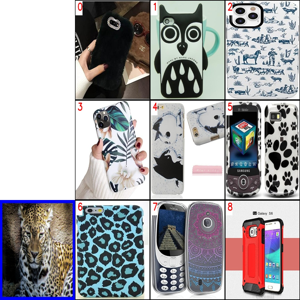

In [10]:
# Create panoramic view
combined_image_path = os.path.join(data_dir, "combined_image.jpg")
panoramic_image = create_panoramic_view(query_image, retrieved_images)
cv2.imwrite(combined_image_path, panoramic_image)

# Display the combined image
combined_image = Image.open(combined_image_path)
show_combined_image = combined_image.resize((300, 300))
display(show_combined_image)


## GPT-4o Ranking and Explanation

Use GPT-4o to analyze the search results and provide intelligent ranking with explanations.


In [ ]:
# OpenAI API configuration
openai_api_key = "sk-***"  # Change to your OpenAI API Key

def generate_ranking_explanation(
    combined_image_path: str, caption: str, infos: dict = None
) -> tuple[list[int], str]:
    """
    Use GPT-4o to analyze search results and provide intelligent ranking.
    
    Args:
        combined_image_path: Path to the combined panoramic image
        caption: User's text query/instruction
        infos: Optional additional information about products
        
    Returns:
        tuple: (ranked_indices, explanation)
    """
    with open(combined_image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    information = (
        "You are responsible for ranking results for a Composed Image Retrieval. "
        "The user retrieves an image with an 'instruction' indicating their retrieval intent. "
        "For example, if the user queries a red car with the instruction 'change this car to blue,' a similar type of car in blue would be ranked higher in the results. "
        "Now you would receive instruction and query image with blue border. Every item has its red index number in its top left. Do not misunderstand it. "
        f"User instruction: {caption} \n\n"
    )

    # Add additional information for each image
    if infos:
        for i, info in enumerate(infos["product"]):
            information += f"{i}. {info}\n"

    information += (
        "Provide a new ranked list of indices from most suitable to least suitable, followed by an explanation for the top 1 most suitable item only. "
        "The format of the response has to be 'Ranked list: []' with the indices in brackets as integers, followed by 'Reasons:' plus the explanation why this most fit user's query intent."
    )

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_api_key}",
    }

    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": information},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            }
        ],
        "max_tokens": 300,
    }

    response = requests.post(
        "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
    )
    result = response.json()["choices"][0]["message"]["content"]

    # Parse the ranked indices from the response
    start_idx = result.find("[")
    end_idx = result.find("]")
    ranked_indices_str = result[start_idx + 1 : end_idx].split(",")
    ranked_indices = [int(index.strip()) for index in ranked_indices_str]

    # Extract explanation
    explanation = result[end_idx + 1 :].strip()

    return ranked_indices, explanation


## Generate AI Ranking and Display Best Result

Use GPT-4o to intelligently rank the search results and display the best match.


In [ ]:
# Generate AI ranking and explanation
ranked_indices, explanation = generate_ranking_explanation(
    combined_image_path, query_text
)

print("AI Ranking Explanation:")
print(explanation)

# Display the best result
best_index = ranked_indices[0]
best_img = Image.open(retrieved_images[best_index])
best_img = best_img.resize((150, 150))
print(f"\nBest match (index {best_index}):")
display(best_img)
